# <center>Data Mining project: Discover and describe areas of interest<br> and events from geo-located parsed_data</center>

# 0/ Import Dataset and Libraries

## #1 Setting Environment

In [1]:
! python -m venv dataMiningEnv
#Activate windows
#! dataMiningEnv\Scripts\activate.bat

#Activate mac
! source dataMiningEnv/bin/activate


Actual environment location may have moved due to redirects, links or junctions.
  Requested location: "h:\IF4\fouilleD\Data-Lyon-Mining_4IF\dataMiningEnv\Scripts\python.exe"
  Actual location:    "\\ps-home.insa-lyon.fr\users\home\dlarrazmar\IF4\fouilleD\Data-Lyon-Mining_4IF\dataMiningEnv\Scripts\python.exe"
'source' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


## #2 Importing Libraries

- ### Installs

>requires: `pip install ipykernel`

In [1]:

# installation of required libraries and dependencies
# numeric calculations
! pip install numpy==1.26.0 
# data frames 
! pip install pandas==2.1.1 
# machine learning algorithms 
! pip install scikit-learn==1.5.1 
# plotting 
! pip install matplotlib==3.8.0 
# Language processing
#! pip install nltk
#! python -m nltk.downloader popular # popular functions
# Folium
! pip install folium==0.12.1


You should consider upgrading via the '\\ps-home.insa-lyon.fr\users\home\dlarrazmar\IF4\fouilleD\Data-Lyon-Mining_4IF\dataMiningEnv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the '\\ps-home.insa-lyon.fr\users\home\dlarrazmar\IF4\fouilleD\Data-Lyon-Mining_4IF\dataMiningEnv\Scripts\python.exe -m pip install --upgrade pip' command.


  Using cached scikit_learn-1.5.1-cp39-cp39-win_amd64.whl (11.0 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached scipy-1.13.1-cp39-cp39-win_amd64.whl (46.2 MB)


You should consider upgrading via the '\\ps-home.insa-lyon.fr\users\home\dlarrazmar\IF4\fouilleD\Data-Lyon-Mining_4IF\dataMiningEnv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the '\\ps-home.insa-lyon.fr\users\home\dlarrazmar\IF4\fouilleD\Data-Lyon-Mining_4IF\dataMiningEnv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the '\\ps-home.insa-lyon.fr\users\home\dlarrazmar\IF4\fouilleD\Data-Lyon-Mining_4IF\dataMiningEnv\Scripts\python.exe -m pip install --upgrade pip' command.


- ###   Imports

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.cluster as cl
import folium
from folium.plugins import MarkerCluster
#import nltk


## #3 Importing Data

In [3]:
# Charger les données avec low_memory=False pour éviter les avertissements
DATA = pd.read_csv("data/flickr_data2.csv", sep=",", low_memory=False)

## #1: Discovering areas of interests using clustering

# I/ Understanding the Data

--Write something to describe this part of the report--

## #1 Data clearing and preparation

In [4]:
# Print details about parsing step:
# -> Number of lines parsed - % of original data parsed
def parse_conclusion(parsed_data):
    l = len(parsed_data)
    print(f"<Lines parsed: {l} - {round(100*l/len(DATA),3)}% of original data>")

- Étape 1 : Nettoyage initial des colonnes

In [5]:
# Supprimer les espaces supplémentaires dans les noms des colonnes
parsed_data = DATA
parsed_data.columns = parsed_data.columns.str.strip()

# Convertir les colonnes temporelles en numériques
# Liste des colonnes temporelles
time_columns = [
    'date_taken_minute', 'date_taken_hour', 'date_taken_day',
    'date_taken_month', 'date_taken_year',
    'date_upload_minute', 'date_upload_hour', 'date_upload_day',
    'date_upload_month', 'date_upload_year'
]

# Convertir chaque colonne en int64, remplacer les erreurs par 0
for col in time_columns:
    parsed_data[col] = pd.to_numeric(DATA[col], errors='coerce').fillna(0).astype('int64')

- Étape 2 : Suppression des doublons basés sur l'identifiant unique

In [6]:
# Sauvegarder les doublons pour audit futur
duplicate_data = parsed_data[parsed_data['id'].duplicated(keep='first')].sort_values("id")
duplicate_data.to_csv(
    "data/parsed_lines/duplicatedId.csv", index=False
)

# Supprimer les doublons
parsed_data = parsed_data[~parsed_data['id'].duplicated(keep='first')]

parse_conclusion(duplicate_data)

<Lines parsed: 252143 - 60.0% of original data>


- Étape 3 : Gestion des colonnes inutilisées ou corrompues

In [7]:
# Identifier les colonnes inutiles
unused_columns = ["Unnamed: 16", "Unnamed: 17", "Unnamed: 18", 
                  "date_upload_minute", "date_upload_hour", "date_upload_day", 
                  "date_upload_month", "date_upload_year"]

# Sauvegarder les données corrompues
corrupted_data = parsed_data[parsed_data["Unnamed: 16"].notnull() | parsed_data["Unnamed: 17"].notnull() | parsed_data["Unnamed: 18"].notnull()]
corrupted_data.to_csv(
    "data/parsed_lines/corrupted_data.csv"
, index=False)


# Supprimer les colonnes inutilisées et les lignes corrompues
parsed_data = parsed_data[~(parsed_data["Unnamed: 16"].notnull() | parsed_data["Unnamed: 17"].notnull() | parsed_data["Unnamed: 18"].notnull())]
parsed_data = parsed_data.drop(columns=unused_columns)

parse_conclusion(corrupted_data)

<Lines parsed: 47 - 0.011% of original data>


- Étape 4 : Nettoyage des coordonnées GPS exterieures à Lyon

In [8]:
# Définir les limites géographiques de Lyon
lyon_lat_min, lyon_lat_max = 45.69, 45.85
lyon_lon_min, lyon_lon_max = 4.78, 4.92

# Sauvegarder les données not Lyonnaises ou non definies
out_lyon_data = parsed_data[
    ~((parsed_data['lat'] >= lyon_lat_min) & 
    (parsed_data['lat'] <= lyon_lat_max) &
    (parsed_data['long'] >= lyon_lon_min) &
    (parsed_data['long'] <= lyon_lon_max))
]
out_lyon_data.to_csv(
    "data/parsed_lines/out_lyon.csv"
, index=False)

# Filtrer les données pour garder uniquement les points dans Lyon
parsed_data = parsed_data[
    (parsed_data['lat'] >= lyon_lat_min) & 
    (parsed_data['lat'] <= lyon_lat_max) &
    (parsed_data['long'] >= lyon_lon_min) &
    (parsed_data['long'] <= lyon_lon_max)
]

parse_conclusion(out_lyon_data)

<Lines parsed: 10502 - 2.499% of original data>


- Étape 5 : Gestion des valeurs manquantes

In [9]:
# Supprimer les lignes avec des valeurs manquantes
#parsed_data = parsed_data.dropna(subset=['id', 'user', 'lat', 'long', 'tags', 'title', 'date_taken_minute', 'date_taken_hour', 'date_taken_day', 'date_taken_month', 'date_taken_year'])

# Sauvegarder les lignes à données manquantes
val_manquante_data = parsed_data[parsed_data.drop(columns=['tags','title']).isna().any(axis = 1)]
val_manquante_data.to_csv(
    "data/parsed_lines/NaNs.csv"
, index=False)

# Remplir les valeurs manquantes pour les colonnes textuelles par des chaînes vides
parsed_data['tags'] = parsed_data['tags'].fillna('')
parsed_data['title'] = parsed_data['title'].fillna('')

parse_conclusion(val_manquante_data)

<Lines parsed: 0 - 0.0% of original data>


- Étape 6 : Filtrage des dates incohérentes

In [10]:
min_year = 2009

# Sauvegarder les données ayant des date non correcte
uncorrect_date_data = parsed_data[
    ~((parsed_data['date_taken_year'] >= min_year) & (parsed_data['date_taken_year'] <= 2025) &
    (parsed_data['date_taken_month'] >= 1) & (parsed_data['date_taken_month'] <= 12) &
    (parsed_data['date_taken_day'] >= 1) & (parsed_data['date_taken_day'] <= 31) &
    (parsed_data['date_taken_hour'] >= 0) & (parsed_data['date_taken_hour'] <= 23) &
    (parsed_data['date_taken_minute'] >= 0) & (parsed_data['date_taken_minute'] <= 59))
]
uncorrect_date_data.to_csv(
    "data/parsed_lines/uncorrect_date.csv"
, index=False)

# Garder uniquement les dates raisonnables (entre 2009 et 2025)
parsed_data = parsed_data[
    (parsed_data['date_taken_year'] >= min_year) & (parsed_data['date_taken_year'] <= 2025) &
    (parsed_data['date_taken_month'] >= 1) & (parsed_data['date_taken_month'] <= 12) &
    (parsed_data['date_taken_day'] >= 1) & (parsed_data['date_taken_day'] <= 31) &
    (parsed_data['date_taken_hour'] >= 0) & (parsed_data['date_taken_hour'] <= 23) &
    (parsed_data['date_taken_minute'] >= 0) & (parsed_data['date_taken_minute'] <= 59) 
]

parse_conclusion(uncorrect_date_data)

<Lines parsed: 2028 - 0.483% of original data>


- Étape 7 : Nettoyage/Standarisation des colonnes textuelles

In [11]:
# Fonction pour nettoyer le texte
def clean_text(text):
    # Supprimer les caractères spéciaux et passer en minuscules
    return re.sub(r'[^a-zA-Z0-9, ]', '', text).lower()

# Appliquer le nettoyage sur les colonnes textuelles
parsed_data['tags'] = parsed_data['tags'].apply(clean_text)
parsed_data['title'] = parsed_data['title'].apply(clean_text)

- Résultat final

In [12]:
# Résumé final des données nettoyées
print("Données nettoyées :")

# Sauvegarder les données nettoyées pour les prochaines étapes
parsed_data.to_csv("data/cleaned_flickr_data.csv", index=False)

parsed_data.head(5)

Données nettoyées :


,id,user,lat,long,tags,title,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year
0,4395181099,30624617@N03,45.754858,4.821710,"chair,lyon,rhne,chaise,rhnealpes",chaises avec vue,11,15,28,2,2010
1,4394748717,35853470@N00,45.753270,4.862953,,,51,17,28,2,2010
2,4394694699,11817998@N05,45.760655,4.846564,"365,iphone",59365 r46 v103 b163,29,17,28,2,2010
3,4394803790,11545749@N06,45.784000,4.874072,"nin,nineinchnails,gift,screening,toiou,avott",20100129 toiou avott lyon,15,20,28,1,2010
4,4394803554,11545749@N06,45.784000,4.874072,"lyon,nin,nineinchnails,gift,screening,toiou,avott",20100128 toiou avott lyon,10,20,28,1,2010


## #2 Visualize Data on map

In [22]:
# Define the center of Lyon
lyon_lat, lyon_lon = 45.75, 4.85  # Approximate coordinates for Lyon, France

# Create a Folium map
map_lyon = folium.Map(location=[lyon_lat, lyon_lon], zoom_start=12)

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(map_lyon)

# Add points from the dataset
for _, row in parsed_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],  # Replace with 'lat' and 'long' if necessary
        popup=f"Tags: {row['tags']}, Title: {row['title']}",  # Optional popup information
    ).add_to(marker_cluster)

# Display the map
map_lyon

# Optional: Save the map as an HTML file
map_lyon.save("lyon_map_unclustered.html")

## #3 Clustering data

To cluster the geo-located data from Lyon, we will apply multiple clustering techniques to identify areas of interest and patterns of activity.

Our aim is to :

- Identify dense regions of photo-taking activity, which may correspond to points of interest (e.g., landmarks, parks).
- Highlight outliers or isolated points that may not belong to any significant cluster.
- Compare different clustering techniques to determine the most effective one for this dataset.

In [13]:
clustered_data = parsed_data
features = ["lat","long"]

### a) K-means

>Why? Suitable for finding spherical clusters in data.<br>
Input required: Number of clusters (k).<br>
Steps: Apply K-Means with varying values of k to find the optimal number of clusters using the elbow method.


- Finding K with the elbow method

C:\Users\dlarrazmar\AppData\Local\Temp\ipykernel_4976\3731107169.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ks_df = pd.concat([ks_df, new_row], ignore_index=True)


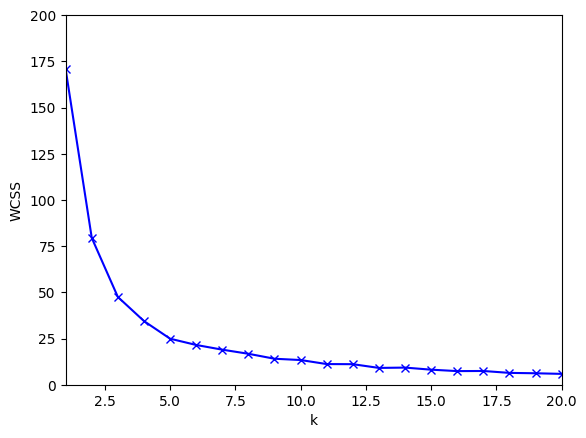

In [14]:
ks_df = pd.DataFrame(columns=["k", "WCSS"])
for k in range(1,21):
    kmeans = cl.KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(clustered_data[features])
    new_row = pd.DataFrame({"k": [k], "WCSS": [kmeans.inertia_]})
    ks_df = pd.concat([ks_df, new_row], ignore_index=True)

plt.axis([1, 20, 0, 200])
plt.xlabel("k")
plt.ylabel("WCSS")
plt.plot(ks_df["k"], ks_df["WCSS"], "-xb")

We observe that the best k from the elbow method is k = 5

- Clustering data

In [15]:
# number of clusters 
k = 5 # set to optimal k found with elbow method
# create a model
kmeans = cl.KMeans(n_clusters=k, init='k-means++')
# fit scaled data
kmeans.fit(clustered_data[["lat","long"]])
# Add labels to data
K_mean_labels = kmeans.labels_
clustered_data = clustered_data.join(pd.DataFrame({"cluster kmeans": K_mean_labels}))

- Visualizing results

In [16]:
# Evaluate clustering
inertia = kmeans.inertia_
# sample_silhouette_values = silhouette_samples(clustered_data[features], K_mean_labels)
# means_lst = []
# for label in range(k):
#     means_lst.append(sample_silhouette_values[K_mean_labels == label].mean())


print(f"Sum of squared distances: {kmeans.inertia_}")
# print(f"Mean silouette scores for each cluster:\n{means_lst}")


clustered_data.head(10)

Sum of squared distances: 24.909855493936142


,id,user,lat,long,tags,title,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year,cluster kmeans
0,4395181099,30624617@N03,45.754858,4.821710,"chair,lyon,rhne,chaise,rhnealpes",chaises avec vue,11,15,28,2,2010,1.0
1,4394748717,35853470@N00,45.753270,4.862953,,,51,17,28,2,2010,3.0
2,4394694699,11817998@N05,45.760655,4.846564,"365,iphone",59365 r46 v103 b163,29,17,28,2,2010,1.0
3,4394803790,11545749@N06,45.784000,4.874072,"nin,nineinchnails,gift,screening,toiou,avott",20100129 toiou avott lyon,15,20,28,1,2010,3.0
4,4394803554,11545749@N06,45.784000,4.874072,"lyon,nin,nineinchnails,gift,screening,toiou,avott",20100128 toiou avott lyon,10,20,28,1,2010,3.0
5,4394566432,16197488@N06,45.755940,4.833158,"poste,lyon,streetphotography,rue,gens",,57,12,27,2,2010,1.0
6,4393799139,16197488@N06,45.754289,4.832257,"lyon,streetphotography,rue,gens",,8,11,27,2,2010,1.0
7,4394565970,16197488@N06,45.774662,4.834005,"lyon,streetphotography,rue,montblanc,gens,mont...",,23,10,27,2,2010,1.0
8,4392370105,47924539@N05,45.762328,4.827547,"france,lyon,lesphotosdevoyage",courette lyonnaise,29,12,27,2,2010,1.0
9,4392367159,47924539@N05,45.762059,4.822654,"france,lyon,fourvire,lesphotosdevoyage",fourvire,28,12,27,2,2010,1.0


### b) DBSCAN

- Clustering Data

In [ ]:
meters = 25
eps = meters / 6371 / 1000 # eps in kilometers
# Initialize DBSCAN with Haversine metric
dbscan = cl.DBSCAN(eps=eps, min_samples=5, metric='haversine')
dbscan.fit(clustered_data[features])

- Visualizing results

In [ ]:
# Access results
DBSCAN_labels = dbscan.labels_
core_samples = dbscan.core_sample_indices_
components = dbscan.components_

# Print the results
print("Cluster labels:", DBSCAN_labels)
print("Core sample indices:", core_samples)
print("Core sample components:\n", components)

à regarder!!!!!!!!!!!!!!!
# add labels to data 
#clustered_data = clustered_data.join(pd.DataFrame({"cluster DBSCAN": DBSCAN_labels}))
#DB_clustered_data["cluster"] = labels
#clustered_df = DB_clustered_data[DB_clustered_data["cluster"] != -1] 

### c) Hierarchical Clustering

>Why? Provides a dendrogram to visualize the hierarchy of clusters.<br>
Input required: No predefined number of clusters; can be adjusted by cutting the dendrogram.<br>
Steps: Compute a linkage matrix using ward or other linkage methods. Cut the dendrogram to form clusters.

In [ ]:
# 1. Préparation des données
geo_data = parsed_data[features]

# Sous-échantillonnage des données (garder n points aléatoires pour éviter les blocages)
geo_data_sampled = geo_data.sample(n=10000, random_state=42)

# 2. Création de la matrice de linkage avec les données échantillonnées
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

linkage_matrix = linkage(geo_data_sampled, method='ward')

# 3. Visualisation du dendrogramme
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Truncate pour simplifier la visualisation
plt.title("Dendrogramme (Clustering Hiérarchique - Échantillonné)")
plt.xlabel("Points de données")
plt.ylabel("Distance")
plt.show()

# 4. Découpage du dendrogramme pour obtenir les clusters
num_clusters = 5
sampled_clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Ajouter les clusters à l'échantillon pour analyse
geo_data_sampled['hierarchical_cluster'] = sampled_clusters

- Visualizing results

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(geo_data_sampled['long'], geo_data_sampled['lat'], c=geo_data_sampled['hierarchical_cluster'], cmap='tab10', s=50)
plt.title(f"Clustering Hiérarchique (Nombre de clusters: {num_clusters})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()